- Jennifer Patricia
- 2602186472

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("product-labeling.csv")
df.head()

,Unnamed: 0,text,label
0,0,Tamron AF 70-300mm F/4.0-5.6 Di LD Macro Telep...,Electronics
1,1,Softline Butterfly Women's Cotton Camisole,Clothing & Accessories
2,2,Indian Economy: For UPSC Civil Services & Othe...,Books
3,3,Fujifilm X-T3 Mirrorless Digital Camera with X...,Electronics
4,4,"Barata Formal Ties For Men, Navy Blue Tie Form...",Clothing & Accessories


In [ ]:
df.info() #no empty value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12606 entries, 0 to 12605
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12606 non-null  int64 
 1   text        12606 non-null  object
 2   label       12606 non-null  object
dtypes: int64(1), object(2)
memory usage: 295.6+ KB


In [13]:
df.drop(df.columns[0], axis=1, inplace=True)

In [33]:
df["label"].value_counts()

label
Household                 4839
Books                     2962
Electronics               2615
Clothing & Accessories    2190
Name: count, dtype: int64

The class frequencies for household label is imbalanced, so additional techniques for handling imbalance are necessary. i decided to tackle this by using synonim augmentation which works by adding some new sentences for minority labels with their synonims using "nltk" and "SynonymAug" libraries

# Data Augmentation

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
from nlpaug.augmenter.word import SynonymAug

aug = SynonymAug(aug_src='wordnet')
text = df["text"].iloc[1]
augmented_text = aug.augment(text)

print(text)
print(augmented_text)

Softline Butterfly Women's Cotton Camisole
["Softline Butterfly stroke Women ' s Cotton plant Underbodice"]


In [ ]:
def augment_label(label, df):
    target_count = len(df[df["label"] == "Household"])

    label_data = df[df['label'] == label]
    current_count = len(label_data)  
    
    num_augmentations = target_count - current_count #to get how many entries needed to generate
    
    augmented_texts = []
    for i in range(num_augmentations):
        text = label_data['text'].iloc[0] 
        augmented_text = aug.augment(text) #applying the command
        augmented_texts.append(augmented_text) #storing each augmented text into list
    
    #converting the results list into data frame format
    augmented_df = pd.DataFrame({'label': [label] * len(augmented_texts), 'text': augmented_texts})
    df = pd.concat([df, augmented_df], ignore_index=True)
    
    return df

# Augmentation only for Books, Electronics, dan Clothing & Accessories labels
df_aug = df.copy()
df_aug = augment_label('Books',df_aug)
df_aug = augment_label('Electronics',df_aug)
df_aug = augment_label('Clothing & Accessories',df_aug)

df_aug["label"].value_counts()

label
Electronics               4839
Clothing & Accessories    4839
Books                     4839
Household                 4839
Name: count, dtype: int64

In [64]:
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=9)
print("Shape of X_train: ", x_train.shape)
print("Shape of X_test: ", x_test.shape)

Shape of X_train:  (10084,)
Shape of X_test:  (2522,)


In [65]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
label_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"{"label"}= {label_dict}")
    
y_train

label= {'Books': 0, 'Clothing & Accessories': 1, 'Electronics': 2, 'Household': 3}


array([0, 0, 1, ..., 3, 3, 1])

## Data Preprocessing

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    #tokenization
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        # removing stop words, punctuation, numbers, emails,currency and random characters(including nonalphabetic langs)
        if (token.is_stop or token.is_punct or token.is_digit or token.like_email 
            or token.is_currency or not token.is_alpha or not token.is_ascii):
            continue
        #lemmatizer
        filtered_tokens.append(token.lemma_.lower())
    
    return " ".join(filtered_tokens) #converting tokenization to a single sentence


In [227]:
test= "i AWW Wanted to eat $ 35 oranges yesterday  你好 我, œ203dpi xx6f0"
preprocess(test)

'aww want eat orange yesterday'

In [54]:
x_train_clean = [preprocess(text) for text in tqdm(x_train, desc="Processing texts")]
x_train_clean[:10]

Processing texts: 100%|██████████| 10084/10084 [03:16<00:00, 51.43it/s]


['fist god novel review frederick forsyth combine fact fiction fist god forget write novel excitement hysteria plenty credible action new york times book incredible imaginative mind master international intrigue king publisher frederick forsyth combine fact fiction fist god forget write novel excitement hysteria plenty credible action new york times book incredible imaginative mind master international intrigue king product description',
 'wise investments simple guide recently go walk paediatrician ask million dollar question linger mind long time question ideal age retirement consultant like long pause answer possible retire know profession yes way true thing consider enter sixty sure attain financial independence retire happily book small endeavour common man understand basic finance invest intelligently innovative way step achieve financial independence early age lead happy retired life',
 'bold n elegant cool printed bear cartoon printed little boy girl baby clothing set highwaist

In [55]:
x_test_clean= [preprocess(text) for text in tqdm(x_test, desc="Processing texts")]
x_test_clean[:10]

Processing texts:   0%|          | 0/2522 [00:00<?, ?it/s]

Processing texts: 100%|██████████| 2522/2522 [00:42<00:00, 58.88it/s]


['garment steamer gst meet fabric need fast heat ready use second level continuous steam enable rapid removal stubborn crease safe use delicate fabric m flexible fabric hose water tank colored level indicator add convenience foot operate switch light indicator ease use adjustable aluminium double telescopic pole suit different ironing need auto cord wind anti calc system heat protection system tilt wheels ease transportation',
 'armour women sports t shirt',
 'shri sai outdoor furniture double seater hang swing double seater hang swing rattan wrought iron frame tolerable weight kg',
 'ancient india',
 'objective zoology aipmt aiims jipmer amu pmt entrance exams',
 'bomshel babydoll women nightwear lingerie panty baby doll nightwear lingerie panty transparent lace mesh material cute satin bow add subtle sexy touch babydoll nightwear lingerie come matching g string panty free size babydoll nightwear lingerie fit size bust inch waist inch',
 'journey self realization collected talks essay

## Vectorization & Models

### TF-IDF

In [ ]:
param_grid = {
    'SVC__C': [0.1, 1, 10], 
    'SVC__kernel': ['linear', 'rbf','poly','sigmoid'],  
    'SVC__gamma': ['scale', 'auto'],  
}

svc_tf = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),    
    ('SVC', SVC())         
])

grid_search = GridSearchCV(svc_tf, param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(x_train_clean, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

y_pred = grid_search.predict(x_test_clean)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'SVC__C': 10, 'SVC__gamma': 'scale', 'SVC__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       617
           1       0.96      0.96      0.96       428
           2       0.97      0.94      0.96       524
           3       0.96      0.96      0.96       953

    accuracy                           0.96      2522
   macro avg       0.96      0.96      0.96      2522
weighted avg       0.96      0.96      0.96      2522



In [ ]:
param_grid = {
    'RF__n_estimators': [100, 200, 300],
    'RF__max_depth': [None, 10, 20, 30],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],
}

rm_tf = Pipeline([
    ('vectorizer_tfidf', TfidfVectorizer()),    
    ('RF', RandomForestClassifier())         
])

grid_search = GridSearchCV(rm_tf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train_clean, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

y_pred = grid_search.predict(x_test_clean)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'RF__max_depth': None, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5, 'RF__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       617
           1       0.95      0.95      0.95       428
           2       0.97      0.89      0.93       524
           3       0.92      0.96      0.94       953

    accuracy                           0.94      2522
   macro avg       0.95      0.94      0.94      2522
weighted avg       0.94      0.94      0.94      2522



### Gensim

below approach is used to fetch the gensim package i had downloaded before in my data storage

In [ ]:
import gzip
import shutil
from gensim.models import KeyedVectors

input_file = '/Users/jenniferpatricia/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'
output_file = '/Users/jenniferpatricia/gensim-data/word2vec-google-news-300/word2vec-google-news-300.bin'

# Decompress the .gz file 
with gzip.open(input_file, 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

wv = KeyedVectors.load_word2vec_format(output_file, binary=True)

In [ ]:
# filtering the data in x_train_clean dan y_train which are not empty
x_train_clean2, y_train_clean2 = zip(*[(sentence, label) for sentence, label in zip(x_train_clean, y_train) if sentence])
x_test_clean2, y_test_clean2 = zip(*[(sentence, label) for sentence, label in zip(x_train_clean, y_train) if sentence])

In [ ]:
x_train_genvectors = []

for sentence in x_train_clean2 :
    words = sentence.split()  # splitting sentences to words
    vector = wv.get_mean_vector(words)  # gensim vectorization
    x_train_genvectors.append(vector) 

x_test_genvectors = []

for sentence in x_test_clean2:
    words = sentence.split()  
    vector = wv.get_mean_vector(words)
    x_test_genvectors.append(vector) 

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf','poly','sigmoid'], 
    'gamma': ['scale', 'auto'],
}

svc_gm = SVC()

grid_search = GridSearchCV(svc_gm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train_genvectors, y_train_clean2)

print(f"Best parameters found: {grid_search.best_params_}")

y_pred = grid_search.predict(x_test_genvectors)
print(classification_report(y_test_clean2, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2343
           1       0.99      1.00      1.00      1762
           2       0.98      0.98      0.98      2091
           3       0.99      0.99      0.99      3886

    accuracy                           0.99     10082
   macro avg       0.99      0.99      0.99     10082
weighted avg       0.99      0.99      0.99     10082



In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
}

rf_gm = RandomForestClassifier()

grid_search = GridSearchCV(rf_gm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train_genvectors, y_train_clean2)

print(f"Best parameters found: {grid_search.best_params_}")

y_pred = grid_search.predict(x_test_genvectors)
print(classification_report(y_test_clean2, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2343
           1       1.00      1.00      1.00      1762
           2       1.00      1.00      1.00      2091
           3       1.00      1.00      1.00      3886

    accuracy                           1.00     10082
   macro avg       1.00      1.00      1.00     10082
weighted avg       1.00      1.00      1.00     10082



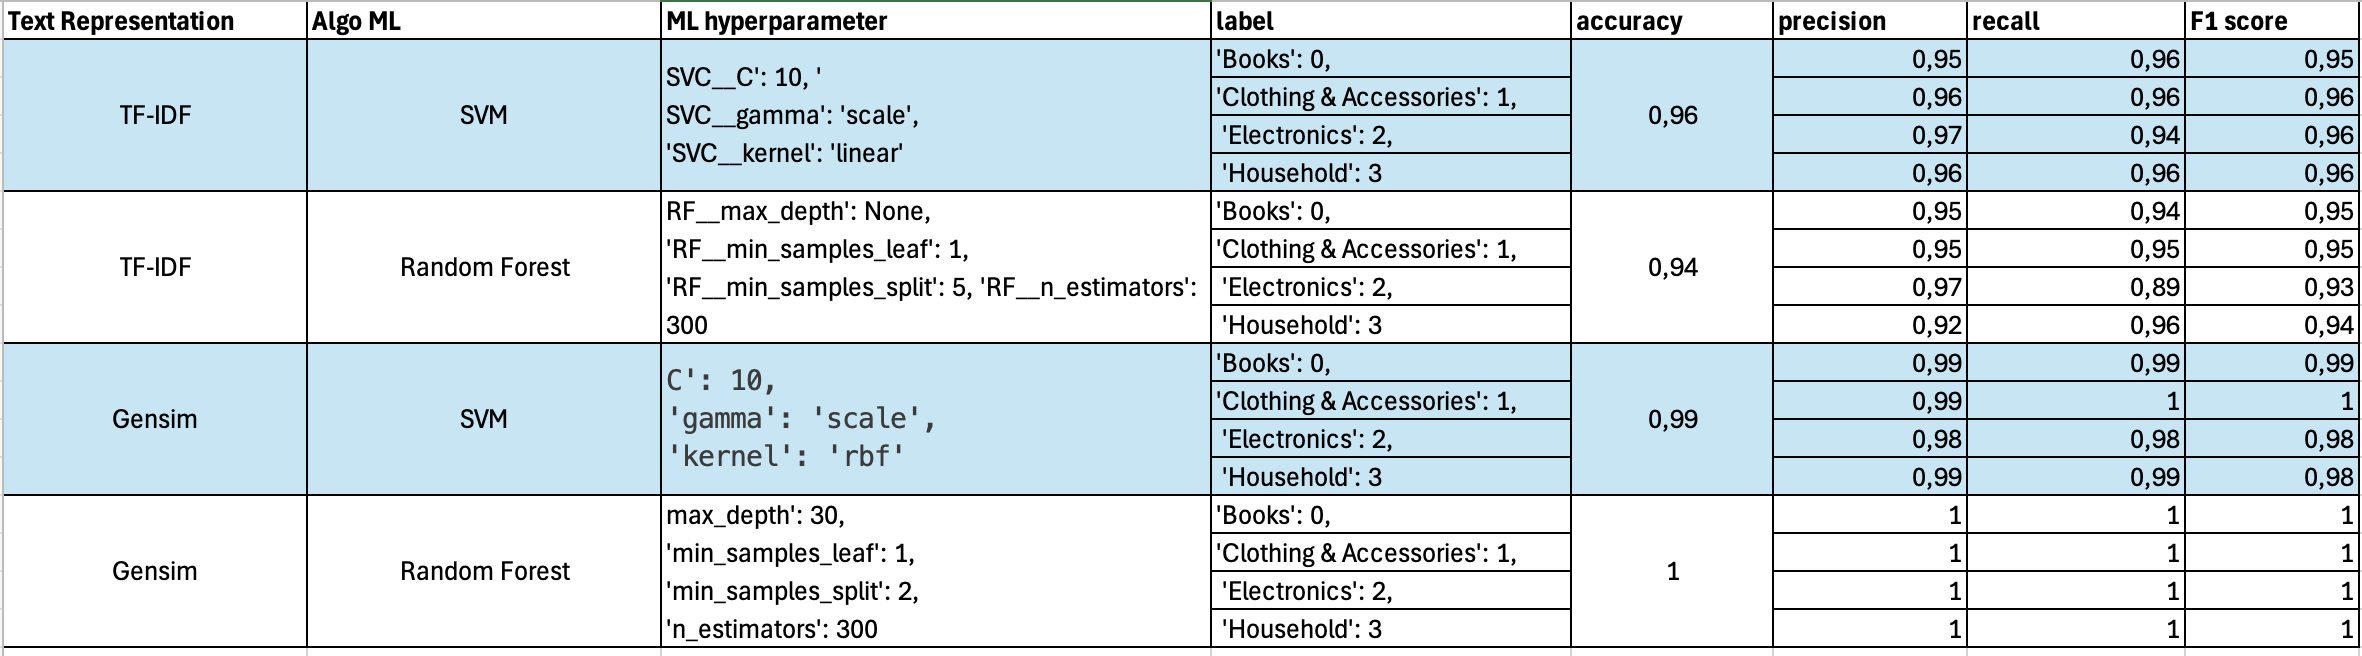

## CONCLUSION:
The best model is the tuned RandomForest classifier using Gensim word embeddings for vectorization, which achieved the highest accuracy. This success can be attributed to the type of vectorization used — Gensim's word embeddings. Word embeddings capture the semantic meaning of words by representing them as dense vectors in a high-dimensional space, allowing the model to understand relationships between words more effectively. Additionally, the tuning of the RandomForest model further enhanced its performance, enabling it to classify the data with greater accuracy. Combining Gensim embeddings with a tuned RandomForest model resulted in the model's superior performance.